# Train and evaluate DFR on ImageNet-9 variations

In [1]:
import sys
import numpy as np
import torch
import torchvision
import einops
import json
import tqdm

from matplotlib import pyplot as plt

import sys

from sklearn.preprocessing import StandardScaler


%matplotlib inline

In [2]:
map_to_in9 = {}
with open('in_to_in9.json', 'r') as f:
    map_to_in9.update(json.load(f))

In [3]:
def load_embeddings(path):
    arr = np.load(path)
    x, y = arr["embeddings"], arr["labels"]
    if np.max(y) > 9:
        y = np.array([map_to_in9[str(y_)] for y_ in y])
        mask = y != -1
        x, y = x[mask], y[mask]
    return x, y

In [4]:
def train_logreg(
    x_train, y_train, eval_datasets, 
    n_epochs=1000, weight_decay=0., lr=1.,
    verbose=0
    ):
    
    x_train = torch.from_numpy(x_train).float().cuda()
    y_train = torch.from_numpy(y_train).long().cuda()
    
    d = x_train.shape[1]
    model = torch.nn.Linear(d, 9).cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(), weight_decay=weight_decay, lr=lr)
    schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        pred = model(x_train)
        loss = criterion(pred, y_train)
        loss.backward()
        optimizer.step()
        schedule.step()
        acc = (torch.argmax(pred, -1) == y_train).detach().float().mean()
        if verbose > 1 and epoch % (n_epochs // 10) == 0:
            print(epoch, acc)
    
    results = {}
    for key, (x_test, y_test) in eval_datasets.items():
        x_test = torch.from_numpy(x_test).float().cuda()
        pred = torch.argmax(model(x_test), axis=-1).detach().cpu().numpy()
        results[key] = (pred == y_test).mean()
    
    pred = torch.argmax(model(x_train), axis=-1)
    results["train"] = (pred == y_train).detach().cpu().float().mean().item()

    return model, results

In [5]:
def get_data(
    train_datasets, eval_datasets, 
    num_mixrand=-1, num_original=0, preprocess=True):
    x_train, y_train = train_datasets["bgc_original"]
    idx = np.arange(len(x_train))
    np.random.shuffle(idx)
    idx = idx[:num_original]
    x_train = x_train[idx]
    y_train = y_train[idx]

    x_train_mr, y_train_mr = train_datasets["bgc_mixedrand"]
    idx = np.arange(len(x_train_mr))
    np.random.shuffle(idx)
    idx = idx[:num_mixrand]
    x_train_mr = x_train_mr[idx]
    y_train_mr = y_train_mr[idx]

    x_train = np.concatenate([x_train, x_train_mr])
    y_train = np.concatenate([y_train, y_train_mr])

    if preprocess:
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        eval_datasets_preprocessed = {
            k: (scaler.transform(x), y)
            for k, (x, y) in eval_datasets.items()
        }
    else:
        eval_datasets_preprocessed = eval_datasets
    return x_train, y_train, eval_datasets_preprocessed


def run_experiment(
    train_datasets, eval_datasets,
    num_mixrand=-1, num_original=0, preprocess=True,
    n_epochs=1000, weight_decay=0., lr=1., verbose=0,
    num_seeds=3
):
    print(lr)
    print(weight_decay)
    print(n_epochs)
    results = {}
    for seed in range(num_seeds):
        x_train, y_train, eval_datasets_preprocessed = get_data(
            train_datasets, eval_datasets,
            num_mixrand, num_original, preprocess)
        _, results_seed = train_logreg(
            x_train, y_train, eval_datasets_preprocessed, 
            n_epochs, weight_decay, lr, verbose)
        results[seed] = results_seed
    
    results_aggrgated = {
        key: (np.mean([results[seed][key] for seed in results.keys()]),
              np.std([results[seed][key] for seed in results.keys()]))
        for key in results[0].keys()
    }
    return results, results_aggrgated


def print_results(results_dict):
    print("-------------------")
    for key, val in results_dict.items():
        print("{}: {:.3f}±{:.3f}".format(key, val[0], val[1]))
    print("-------------------")

## ResNet-50

Change data paths here.

In [6]:
use_prev_layer = False

eval_path_dict = {
    "imagenet_r": f"/home/jennyni/datasets/imagenet-r/imagenet-r_{use_prev_layer}_val_embeddings.npz",
    "imagenet_a": f"/home/jennyni/datasets/imagenet-a/imagenet-a_{use_prev_layer}_val_embeddings.npz",
    "bgc_original": f"/home/jennyni/datasets/bg_challenge/original/bg_challenge_{use_prev_layer}_val_embeddings.npz",
    "bgc_fg": f"/home/jennyni/datasets/bg_challenge/only_fg/bg_challenge_{use_prev_layer}_val_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/bg_challenge/mixed_rand/bg_challenge_{use_prev_layer}_val_embeddings.npz",
    # "bgc_paintings": f"/home/jennyni/datasets/bg_challenge/paintings_bg/bg_challenge_{use_prev_layer}_resnet50_val_embeddings.npz"
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    # "bgc_original": f"/home/jennyni/datasets/original/bg_challenge_{use_prev_layer}_train_standardSL_embeddings.npz",
    # "bgc_mixedrand": f"/home/jennyni/datasets/mixed_rand/bg_challenge_{use_prev_layer}_train_standardSL_embeddings.npz",
    "bgc_original": f"/home/jennyni/datasets/original/bg_challenge_{use_prev_layer}_train_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/mixed_rand/bg_challenge_{use_prev_layer}_train_embeddings.npz",

}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [7]:
ns = [1000, 5000, 10000, 20000, 45405]
num_seeds = 5

### Baseline

In [8]:
# seed_results, results_original = run_experiment(train_datasets, eval_datasets,
#                                                 num_mixrand=0, num_original=-1, num_seeds=num_seeds, n_epochs=2000,
#                                                 weight_decay=100/45405)
# print_results(results_original)

### Mixed-Rand

In [9]:
mixrand_results_ns = []
for n in ns:
    num_mixrand = n
    num_original = 0

    n_data = num_mixrand + num_original
    wd = 100 / n_data
    n_epochs = 2000
    seed_results, results_aggrgated = run_experiment(
        train_datasets, eval_datasets,
        num_mixrand, num_original, weight_decay=wd, n_epochs=n_epochs,
        num_seeds=num_seeds)
    print_results(results_aggrgated)
    mixrand_results_ns.append(results_aggrgated)

1.0
0.1
2000
-------------------
imagenet_r: 0.477±0.016
imagenet_a: 0.271±0.012
bgc_original: 0.936±0.002
bgc_fg: 0.893±0.006
bgc_mixedrand: 0.863±0.003
train: 1.000±0.000
-------------------
1.0
0.02
2000
-------------------
imagenet_r: 0.526±0.012
imagenet_a: 0.282±0.013
bgc_original: 0.948±0.005
bgc_fg: 0.917±0.005
bgc_mixedrand: 0.895±0.004
train: 0.977±0.001
-------------------
1.0
0.01
2000
-------------------
imagenet_r: 0.535±0.006
imagenet_a: 0.282±0.008
bgc_original: 0.951±0.003
bgc_fg: 0.922±0.005
bgc_mixedrand: 0.909±0.001
train: 0.955±0.001
-------------------
1.0
0.005
2000
-------------------
imagenet_r: 0.536±0.006
imagenet_a: 0.285±0.006
bgc_original: 0.958±0.003
bgc_fg: 0.932±0.003
bgc_mixedrand: 0.919±0.001
train: 0.936±0.001
-------------------
1.0
0.0022024006166721727
2000
-------------------
imagenet_r: 0.554±0.000
imagenet_a: 0.286±0.000
bgc_original: 0.963±0.000
bgc_fg: 0.939±0.000
bgc_mixedrand: 0.926±0.000
train: 0.919±0.000
-------------------


### Mixed-Rand + Original

In [10]:
combo_results_ns = []
for n in ns:
    num_mixrand = n
    num_original = n

    n_data = num_mixrand + num_original
    wd = 100 / n_data
    n_epochs = 2000
    seed_results, results_aggrgated = run_experiment(
        train_datasets, eval_datasets,
        num_mixrand, num_original, weight_decay=wd, n_epochs=n_epochs,
        num_seeds=num_seeds)
    print_results(results_aggrgated)
    combo_results_ns.append(results_aggrgated)

1.0
0.05
2000
-------------------
imagenet_r: 0.510±0.015
imagenet_a: 0.316±0.011
bgc_original: 0.960±0.002
bgc_fg: 0.913±0.007
bgc_mixedrand: 0.876±0.005
train: 0.999±0.001
-------------------
1.0
0.01
2000
-------------------
imagenet_r: 0.525±0.019
imagenet_a: 0.308±0.005
bgc_original: 0.968±0.002
bgc_fg: 0.926±0.006
bgc_mixedrand: 0.901±0.004
train: 0.982±0.002
-------------------
1.0
0.005
2000
-------------------
imagenet_r: 0.527±0.006
imagenet_a: 0.311±0.007
bgc_original: 0.969±0.001
bgc_fg: 0.932±0.004
bgc_mixedrand: 0.911±0.001
train: 0.969±0.001
-------------------
1.0
0.0025
2000
-------------------
imagenet_r: 0.544±0.005
imagenet_a: 0.313±0.007
bgc_original: 0.972±0.001
bgc_fg: 0.937±0.002
bgc_mixedrand: 0.920±0.001
train: 0.960±0.001
-------------------
1.0
0.0011012003083360864
2000
-------------------
imagenet_r: 0.556±0.000
imagenet_a: 0.319±0.000
bgc_original: 0.974±0.000
bgc_fg: 0.943±0.000
bgc_mixedrand: 0.925±0.000
train: 0.950±0.000
-------------------


In [11]:
def plot_results(key, ax, ns, mixrand_results_ns, combo_results_ns, results_original):
    mixrand_mu = np.array([results[key][0] for results in mixrand_results_ns])
    mixrand_sigma = np.array([results[key][1] for results in mixrand_results_ns])

    original_mu = np.array([results_original[key][0] for _ in ns])
    original_sigma = np.array([results_original[key][1] for _ in ns])

    combo_mu = np.array([results[key][0] for results in combo_results_ns])
    combo_sigma = np.array([results[key][1] for results in combo_results_ns])
    ax.plot(ns, mixrand_mu, "-bo", label="DFR MR")
    ax.fill_between(ns, mixrand_mu + mixrand_sigma, mixrand_mu - mixrand_sigma,
                   color="b", alpha=0.3)
    ax.plot(ns, combo_mu, "-ro", label="DFR MR + Og")
    ax.fill_between(ns, combo_mu + combo_sigma, combo_mu - combo_sigma,
                    color="r", alpha=0.3)
    ax.plot(ns, original_mu, "--g", label="DFR Og")
    ax.fill_between(ns, original_mu + original_sigma, original_mu - original_sigma,
                    color="g", alpha=0.3)
    
    ax.legend()
    ax.set_xlabel("# MixedRand Data", fontsize=12)
    ax.set_ylabel(f"{key} Test Acc", fontsize=12)

In [12]:
print(combo_results_ns)

[{'imagenet_r': (0.5104353011329756, 0.014972363017504658), 'imagenet_a': (0.3155805846071333, 0.011301827107709715), 'bgc_original': (0.9603456790123456, 0.002155938760784507), 'bgc_fg': (0.9131851851851852, 0.007345585641070647), 'bgc_mixedrand': (0.8764938271604938, 0.0053127173561603215), 'train': (0.9991000056266784, 0.000663312823827469)}, {'imagenet_r': (0.5250911018352878, 0.018815568793173504), 'imagenet_a': (0.30834003754357736, 0.005142684269399035), 'bgc_original': (0.9679506172839506, 0.0019654072831736136), 'bgc_fg': (0.9257777777777777, 0.0057070697138542755), 'bgc_mixedrand': (0.9011358024691358, 0.0038079165725742165), 'train': (0.9822000026702881, 0.0015297118766521471)}, {'imagenet_r': (0.5271582852978203, 0.006235604151442249), 'imagenet_a': (0.3113971574148565, 0.006712571884006242), 'bgc_original': (0.9694320987654322, 0.0011086392257107966), 'bgc_fg': (0.9322962962962963, 0.004272104445211317), 'bgc_mixedrand': (0.9111604938271605, 0.001426126328710476), 'train':

NameError: name 'results_original' is not defined

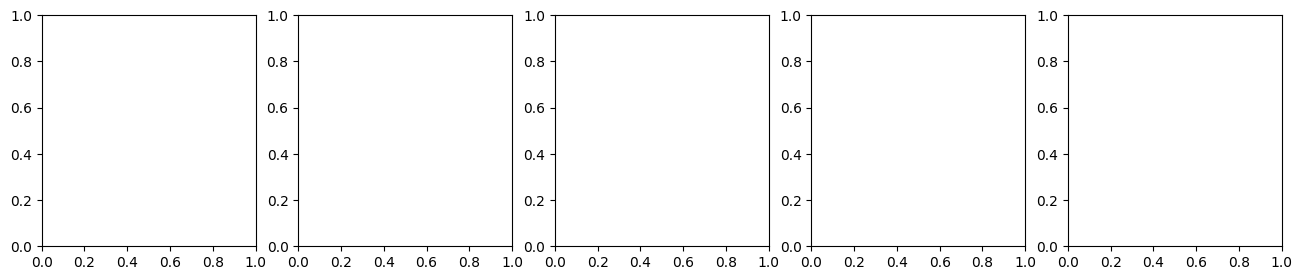

In [13]:
f, arr = plt.subplots(1, 5, figsize=(16, 3))

plot_results("bgc_mixedrand", arr[0], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
plot_results("bgc_fg", arr[1], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
plot_results("bgc_original", arr[2], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
plot_results("imagenet_r", arr[3], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
plot_results("imagenet_a", arr[4], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)
# plot_results("bgc_paintings", arr[5], np.array(ns), mixrand_results_ns, combo_results_ns, results_original)

plt.tight_layout()